In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [2]:
#For a new user that needs to install
#!pip install wrapt --upgrade --ignore-installed
#!pip install tensorflow-gpu
#!pip install keras

In [3]:
import csv
import time
import sys
import os 

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
#put your path in possible_paths 
possible_paths = ["..\\utils\\", "../../utils/"]
for path in possible_paths:
    if os.path.isdir(path):
        utils_path = path
        
sys.path.insert(0, utils_path)   
sys.path.insert(0, utils_path)  

import utils as ut
import fancyplots as fp
from regr_models import neuralNewtorkRegression

In [5]:
#When a library is updated, run
import importlib
importlib.reload(ut)

<module 'utils' from '..\\utils\\utils.py'>

## Input options

In [6]:
# training options
write_output     = False
remove_some_mass = False
epochs           = 10
validation_split = 0.2
batch_size       = 128
verbose_training = False
hlayers_sizes    = (100,);
learning_rate    = 0.001
scaler_type      = 'minmax' # standard, minmax, mixed
hidden_activation= 'relu'
out_activation   = 'linear' 

# data paths
regr_data_dirs = ["../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/m1m2Mc/",
                  "..\\GSTLAL_EarlyWarning_Dataset\\Dataset\\m1m2Mc\\"]
for path in regr_data_dirs:
    if os.path.isdir(path):
        regr_data_dir = path
        print(path)

..\GSTLAL_EarlyWarning_Dataset\Dataset\m1m2Mc\


## Load dataset

In [7]:
# load data
features_names       = ['m1', 'm2', 'Mc']
data_paths           = {}
data_paths['xtrain'] = regr_data_dir+'xtrain.csv'
data_paths['ytrain'] = regr_data_dir+'ytrain.csv'
data_paths['xtest']  = regr_data_dir+'xtest.csv'
data_paths['ytest']  = regr_data_dir+'ytest.csv'

rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                       remove_some_mass=remove_some_mass,
                       scaler_type=None)
xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

## Train and test the model: just throw all into a NN

********************************************************************************
Layers: 100 
trainable pramaters: 703
train time: 3.065
********************************************************************************

Final loss     : 0.03065
Final R2 mean  : 0.84253
R2[ 0]         : 0.74199
R2[ 1]         : 0.78593
R2[ 2]         : 0.99969


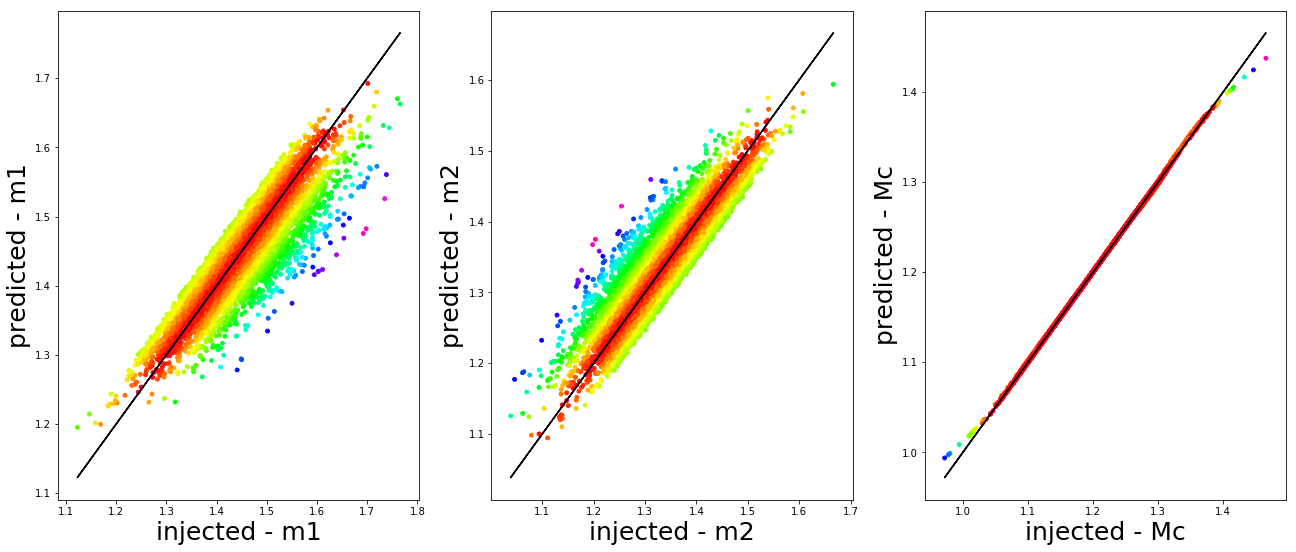

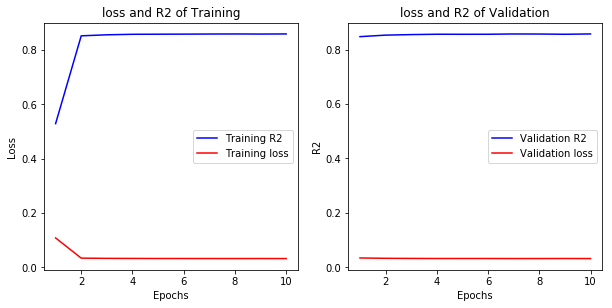

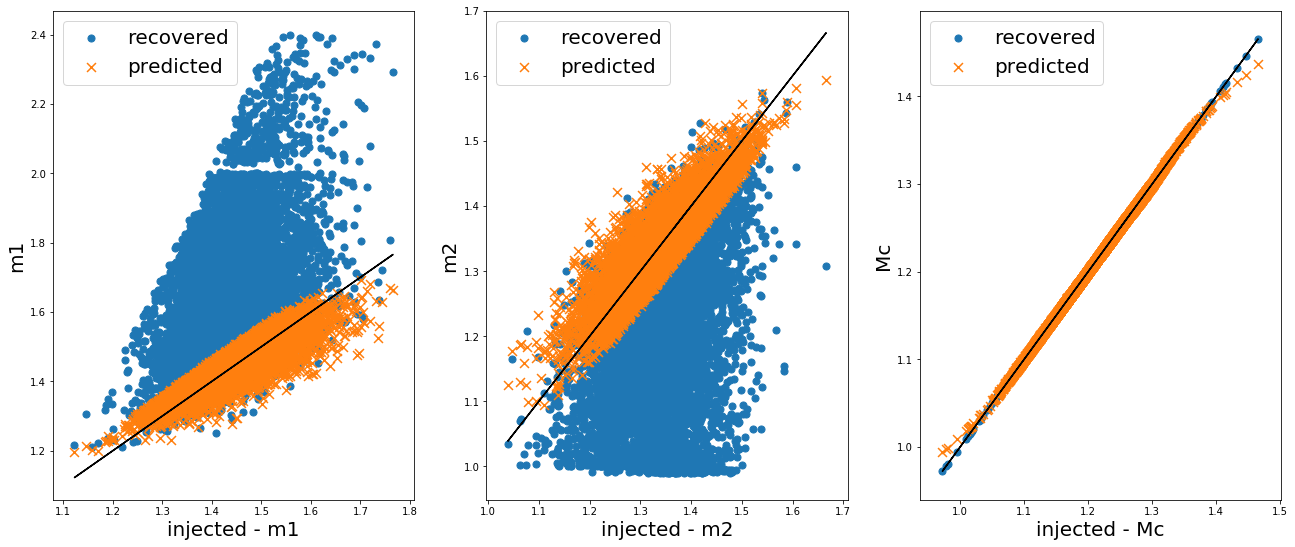

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


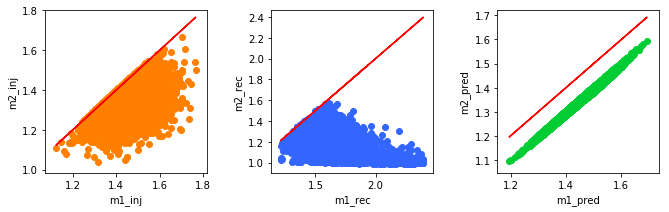

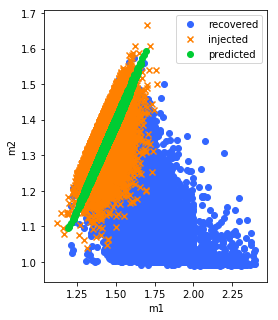

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


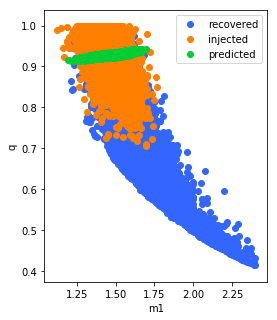

********************************************************************************
m1 vs Mc: injected, recovered, predicted
********************************************************************************


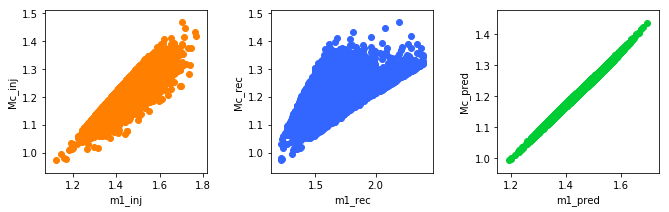

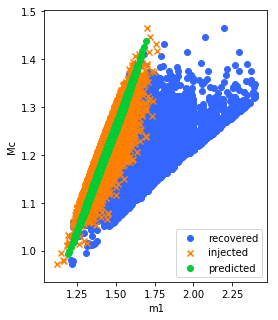

---------------------------------
m1 mean error: 0.02270872698201041
m2 mean error: 0.02235718389757278
Mc mean error: 0.00048468613066204457
q  mean error: 0.04549219478124448


In [8]:
# train model
t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_notnormalized, ytrain_notnormalized,
            scaler_type       = scaler_type,                   
            epochs            = epochs, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = 'mse')
train_time = time.perf_counter()-t0

model    = outNN["model"]
history  = outNN["history"]
Npars    = outNN["Npars"]
scaler_x = outNN["scaler_x"]
scaler_y = outNN["scaler_y"]

xtest = scaler_x.transform(xtest_notnormalized)
ytest = scaler_y.transform(ytest_notnormalized)

# predict
ypredicted = model.predict(xtest)

# print some information
metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes:
    print(layer,end=' ')
print('\ntrainable pramaters: ', Npars, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict)

# save info/score/model in the dictionary
dict1                     = lambda:0
dict1.Npars               = Npars
dict1.metrics             = metrics_dict
dict1.train_time          = train_time
dict1.Nlayers             = len(hlayers_sizes)
dict1.hlayers_sizes       = hlayers_sizes
dict1.epochs              = epochs
dict1.batch_size          = batch_size
dict1.scaler_type         = scaler_type
dict1.out_activation      = out_activation
dict1.hidden_activation   = hidden_activation
dict1.learning_rate       = learning_rate
dict1.prediction          = ypredicted
dict1.prediction_rescaled = scaler_y.inverse_transform(ypredicted)
dict1.loss_function       = 'mse'
dict1.scaler_x            = scaler_x
dict1.scaler_y            = scaler_y
dict1.model               = model
dict1.history             = history

# plots
fp.regrPredictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
fp.plotHistory(history)
fp.checkRegressionPlot(xtest, ytest, ypredicted, labels, \
                   scaler_y=scaler_y, scaler_x=scaler_x)
fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
                  dict1.prediction_rescaled, idx_Mc=2)

# mean errors 
m1_inj  = ytest_notnormalized[:,0]
m2_inj  = ytest_notnormalized[:,1]
Mc_inj  = ytest_notnormalized[:,2]
m1_pred = dict1.prediction_rescaled[:,0]
m2_pred = dict1.prediction_rescaled[:,1]
Mc_pred = dict1.prediction_rescaled[:,2]
q_inj   = m2_inj /m1_inj
q_pred  = m2_pred/m1_pred
m1_mean_error = np.mean(np.abs(m1_inj-m1_pred)/m1_inj)
m2_mean_error = np.mean(np.abs(m2_inj-m2_pred)/m2_inj)
Mc_mean_error = np.mean(np.abs(Mc_inj-Mc_pred)/Mc_inj)
q_mean_error  = np.mean(np.abs(q_inj - q_pred)/q_inj )
print('---------------------------------')
print('m1 mean error:', m1_mean_error)
print('m2 mean error:', m2_mean_error)
print('Mc mean error:', Mc_mean_error)
print('q  mean error:', q_mean_error)

## Test new loss functions

********************************************************************************
Layers: 100 
trainable pramaters: 502
train time: 6.384
********************************************************************************

Final loss     : 0.44486
Final R2 mean  : 0.75966
R2[ 0]         : 0.73769
R2[ 1]         : 0.78163


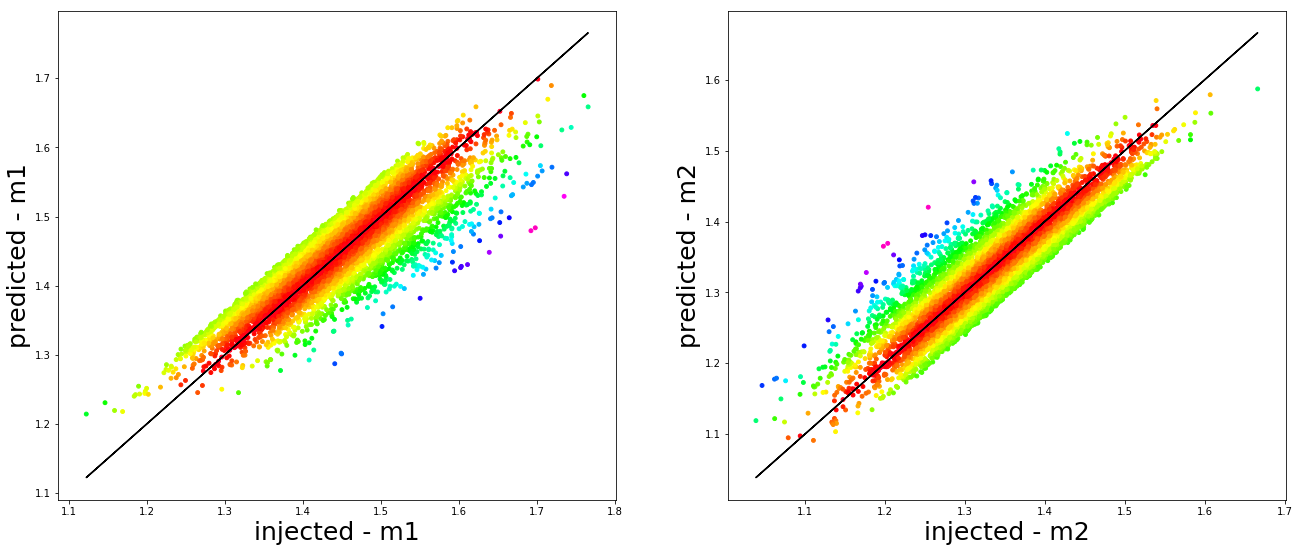

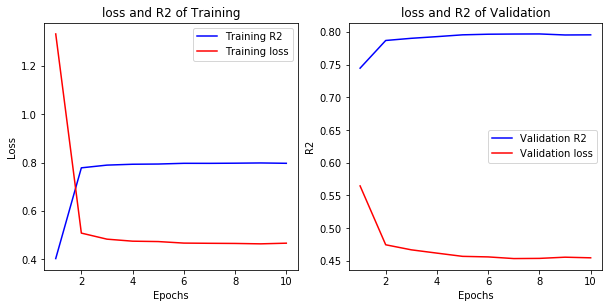

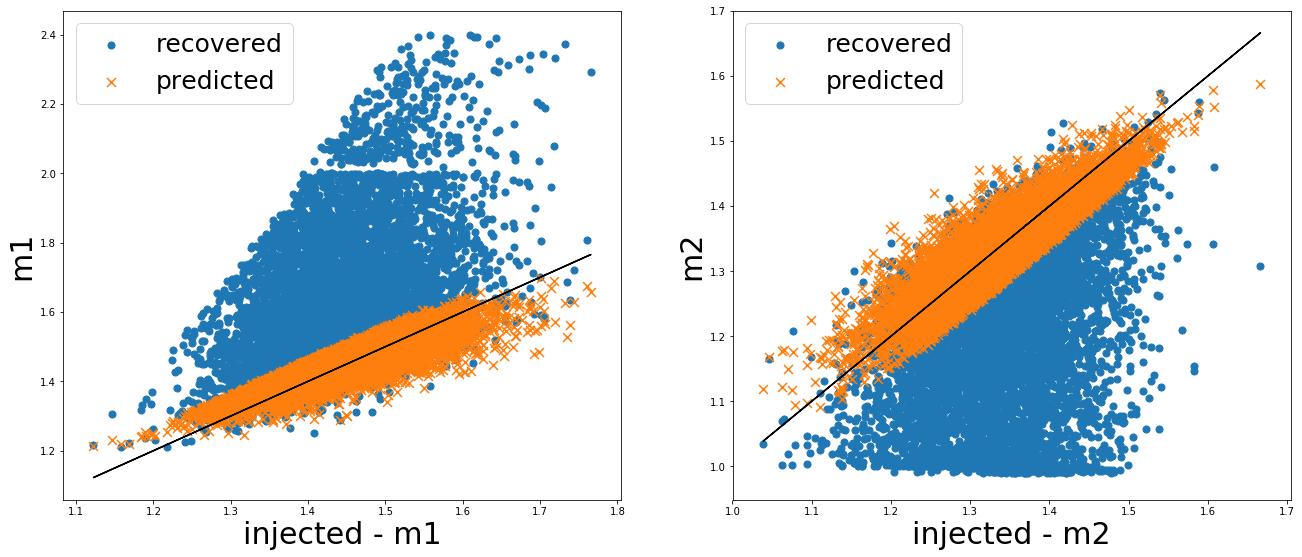

********************************************************************************
m1 vs m2: injected, recovered, predicted
********************************************************************************


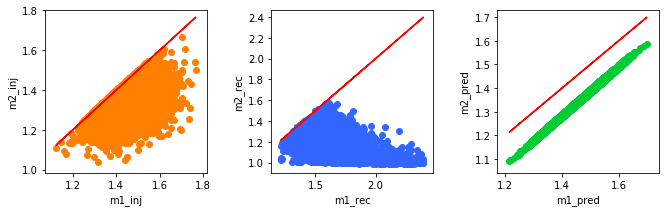

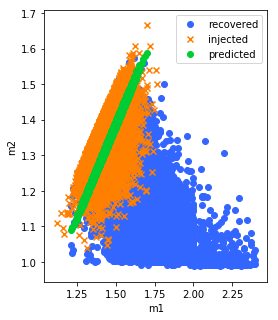

********************************************************************************
m1 vs q: injected, recovered, predicted (indirectly)
********************************************************************************


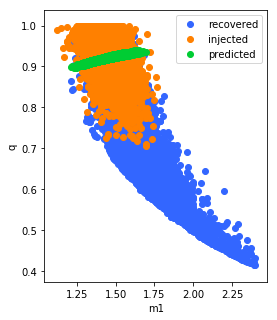

---------------------------------
m1 mean error: 0.023491287520102325
m2 mean error: 0.02296680314730184
Mc mean error: 0.0008397030968210838
q  mean error: 0.04653395974854521


In [9]:
# def values, do not touch! Modify below the dashes
Lambda_q  = 1
Lambda_Mc = 1
SNR_train = None
#--------------------------------------

# old-style loss function, q-penalty
#loss_new  = 'mse_q'
#Lambda_q  = 100

# new loss function (multiplicative), with optional SNR
#loss_new  = 'mse_v1' # Mc-penalty
#Lambda_Mc = 10
#SNR_train =  ut.extractData(regr_data_dir+'SNRtrain.csv', verbose=False)

loss_new  = 'mse_v2' # q-penalty
Lambda_q  = 10
SNR_train = ut.extractData(regr_data_dir+'SNRtrain.csv', verbose=False)




# remove chirp mass
xtrain_new = xtrain_notnormalized[:,0:2]
ytrain_new = ytrain_notnormalized[:,0:2]
xtest_new  = xtest_notnormalized[:,0:2]
ytest_new  = ytest_notnormalized[:,0:2]
labels_new = labels[0:2]

# train model
t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_new, ytrain_new,
            scaler_type       = scaler_type,                   
            epochs            = epochs, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = loss_new,
            Lambda_q          = Lambda_q,
            Lambda_Mc         = Lambda_Mc,
            SNR               = SNR_train)

train_time = time.perf_counter()-t0

model    = outNN["model"]
history  = outNN["history"]
Npars    = outNN["Npars"]
scaler_x = outNN["scaler_x"]
scaler_y = outNN["scaler_y"]

xtest = scaler_x.transform(xtest_new)
ytest = scaler_y.transform(ytest_new)

# predict
ypredicted = model.predict(xtest)

# print some information
metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes:
    print(layer,end=' ')
print('\ntrainable pramaters: ', Npars, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict)

# save info/score/model in the dictionary
dict2                     = lambda:0
dict2.Npars               = Npars
dict2.metrics             = metrics_dict
dict2.train_time          = train_time
dict2.Nlayers             = len(hlayers_sizes)
dict2.hlayers_sizes       = hlayers_sizes
dict2.epochs              = epochs
dict2.batch_size          = batch_size
dict2.scaler_type         = scaler_type
dict2.out_activation      = out_activation
dict2.hidden_activation   = hidden_activation
dict2.learning_rate       = learning_rate
dict2.prediction          = ypredicted
dict2.prediction_rescaled = scaler_y.inverse_transform(ypredicted)
dict2.loss_function       = loss_new
dict2.scaler_x            = scaler_x
dict2.scaler_y            = scaler_y
dict2.model               = model
dict2.history             = history

# plots
fp.regrPredictionPlots(ytest, ypredicted, labels_new, scaler=scaler_y)
fp.plotHistory(history)
fp.checkRegressionPlot(xtest, ytest, ypredicted, labels_new, \
                   scaler_y=scaler_y, scaler_x=scaler_x)
fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
                  dict2.prediction_rescaled, idx_Mc=None)

# mean errors 
m1_inj  = ytest_new[:,0]
m2_inj  = ytest_new[:,1]
Mc_inj  = ut.chirpMass(m1_inj, m2_inj)
q_inj   = m2_inj /m1_inj
m1_pred = dict2.prediction_rescaled[:,0]
m2_pred = dict2.prediction_rescaled[:,1]
Mc_pred = ut.chirpMass(m1_pred,m2_pred)
q_pred  = m2_pred/m1_pred
m1_mean_error = np.mean(np.abs(m1_inj-m1_pred)/m1_inj)
m2_mean_error = np.mean(np.abs(m2_inj-m2_pred)/m2_inj)
Mc_mean_error = np.mean(np.abs(Mc_inj-Mc_pred)/Mc_inj)
q_mean_error  = np.mean(np.abs(q_inj - q_pred)/q_inj )
print('---------------------------------')
print('m1 mean error:', m1_mean_error)
print('m2 mean error:', m2_mean_error)
print('Mc mean error:', Mc_mean_error)
print('q  mean error:', q_mean_error)

del loss_new

## Penalty in q, (p^3, s)

In [18]:
epochs_fp        = 20
hlayers_sizes_fp = (100,); 
pcoeff           = 3
loss_function_fp  = 'mse_q_p3s' # q-penalty
Lambda_q  = 2.5
Lambda_Mc = 1
save=True
show=True
SNR_train = None

name_plots='lambda'+str(Lambda_q*10)+'p3s_'

#    layers.append(hlayers_sizes_fp[0])

xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

Ntrain = len(xtrain_notnormalized[:,0])
Ntest  = len(xtest_notnormalized[:,1])
xtrain_notnorm_fp = np.zeros((Ntrain,2))
ytrain_notnorm_fp = np.zeros((Ntrain,2))
xtest_notnorm_fp  = np.zeros((Ntest,2))
ytest_notnorm_fp  = np.zeros((Ntest,2))

m1_rec_train = xtrain_notnormalized[:,0]
m2_rec_train = xtrain_notnormalized[:,1]
m1_inj_train = ytrain_notnormalized[:,0]
m2_inj_train = ytrain_notnormalized[:,1]
m1_rec_test  = xtest_notnormalized[:,0]
m2_rec_test  = xtest_notnormalized[:,1]
m1_inj_test  = ytest_notnormalized[:,0]
m2_inj_test  = ytest_notnormalized[:,1]

xtrain_notnorm_fp[:,0] = (m1_rec_train*m2_rec_train)**pcoeff
xtrain_notnorm_fp[:,1] = (m1_rec_train+m2_rec_train)
ytrain_notnorm_fp[:,0] = (m1_inj_train*m2_inj_train)**pcoeff
ytrain_notnorm_fp[:,1] =(m1_inj_train+m2_inj_train)
xtest_notnorm_fp[:,0]  = (m1_rec_test*m2_rec_test)**pcoeff
xtest_notnorm_fp[:,1]  = m1_rec_test+m2_rec_test
ytest_notnorm_fp[:,0]  = (m1_inj_test*m2_inj_test)**pcoeff
ytest_notnorm_fp[:,1]  = (m1_inj_test+m2_inj_test)

labels_fp = ['p'+str(pcoeff), 's']

# train model
t0 = time.perf_counter()
outNN = neuralNewtorkRegression(xtrain_notnorm_fp, ytrain_notnorm_fp,
            scaler_type       = scaler_type,                   
            epochs            = epochs_fp, 
            batch_size        = batch_size, 
            learning_rate     = learning_rate,          
            validation_split  = validation_split,   
            verbose           = verbose_training,             
            hlayers_sizes     = hlayers_sizes,          
            out_activation    = out_activation,        
            hidden_activation = hidden_activation,
            loss_function     = loss_function_fp,
            Lambda_q          = Lambda_q,
            Lambda_Mc         = Lambda_Mc,
            SNR               = SNR_train)
train_time = time.perf_counter()-t0

model_fp    = outNN["model"]
history_fp  = outNN["history"]
Npars_fp    = outNN["Npars"]
scaler_x_fp = outNN["scaler_x"]
scaler_y_fp = outNN["scaler_y"]

xtest_fp = scaler_x_fp.transform(xtest_notnorm_fp)
ytest_fp = scaler_y_fp.transform(ytest_notnorm_fp)

# predict
ypredicted_fp = model_fp.predict(xtest_fp)
print("Model trained, predictions made")

# print some information
metrics_dict_fp = ut.evalutationMetricsDict(xtest_fp,ytest_fp,model_fp)

# show plots and print info
asterisks = '*'*80
print(asterisks)
print('Layers: ', end='')
for layer in hlayers_sizes_fp:
    print(layer,end=' ')
print('\ntrainable paramaters: ', Npars_fp, \
      '\ntrain time: {:.3f}'.format(train_time), '\n', \
      asterisks, sep='', end='\n')
ut.printMetrics(metrics_dict_fp)

# save info/score/model in the dictionary
dict4                     = lambda:0
dict4.Npars               = Npars_fp
dict4.metrics             = metrics_dict_fp
dict4.train_time          = train_time
dict4.Nlayers             = len(hlayers_sizes)
dict4.hlayers_sizes       = hlayers_sizes_fp
dict4.epochs              = epochs_fp
dict4.batch_size          = batch_size
dict4.scaler_type         = scaler_type
dict4.out_activation      = out_activation
dict4.hidden_activation   = hidden_activation
dict4.learning_rate       = learning_rate
dict4.prediction          = ypredicted_fp
dict4.prediction_rescaled = scaler_y_fp.inverse_transform(ypredicted_fp)
dict4.loss_function       = loss_function_fp
dict4.scaler_x            = scaler_x_fp
dict4.scaler_y            = scaler_y_fp
dict4.model               = model_fp
dict4.history             = history_fp

# PLOTS
fp.regrPredictionPlots(ytest_fp, ypredicted_fp, labels_fp, scaler=scaler_y_fp,save=save, show=show,figname=name_plots); 
fp.plotHistory(history_fp,save=save, show=show,figname=name_plots);
fp.checkRegressionPlot(xtest_fp, ytest_fp, ypredicted_fp, labels_fp, \
                   scaler_y=scaler_y_fp, scaler_x=scaler_x_fp,save=save, show=show,figname=name_plots);

p_pred  = dict4.prediction_rescaled[:,0]
s_pred = dict4.prediction_rescaled[:,1]
Mc_pred = (p_pred/s_pred)**(1.0/5)

m1_pred, m2_pred= ut.findm1m2Fromps(p_pred,s_pred)

if(np.max(m1_pred)>3.2):
    print("Warning: BH mass recovered as m1")

# now check consistency between m1,m2 and Mc
Mc_inj=ytest_notnormalized[:,2]
m2_pred_from_MC = ut.findSecondMassFromMc(Mc_inj, m1_pred)

if (np.max(np.abs(m2_pred_from_MC-m2_pred))>0.02):
    print("Warning: too much difference in m2")
#plt.title('Difference of m2 predicted by (Mc,m1) and (p,s)')
#plt.ylabel('difference');plt.plot(m2_pred_from_MC-m2_pred,'o');
#plt.savefig(name_plots+'m2_dif.png')


# check that m1 is always the biggest
for i in range(0,len(m2_pred)):
    if m2_pred[i]>m1_pred[i]:
        tmp        = m2_pred[i]
        m2_pred[i] = m1_pred[i]
        m1_pred[i] = tmp
        #print(i, 'swapping')

Mc_pred=(p_pred/s_pred)**(1.0/5)

#PLOTS
prediction_fp = np.column_stack((m1_pred, m2_pred, Mc_pred))
fp.plotInjRecPred(ytest_notnormalized, xtest_notnormalized, \
                  prediction_fp, idx_Mc=2,save=save, show=show,figname=name_plots)



nan_counter = 0;
for i in range(0,len(m1_pred)):
    if np.isnan(m1_pred[i]):
        #print(p_pred[i], Mc_pred[i])
        nan_counter += 1
print(asterisks, '\nNaN found:', nan_counter)

# mean errors 
m1_inj  = ytest_notnormalized[:,0]
m2_inj  = ytest_notnormalized[:,1]
Mc_inj  = ytest_notnormalized[:,2]
q_inj   = m2_inj /m1_inj
q_pred  = m2_pred/m1_pred

m1_mean_error = np.mean(np.abs(m1_inj-m1_pred)/m1_inj)
m2_mean_error = np.mean(np.abs(m2_inj-m2_pred)/m2_inj)
Mc_mean_error = np.mean(np.abs(Mc_inj-Mc_pred)/Mc_inj)
q_mean_error  = np.mean(np.abs(q_inj - q_pred)/q_inj )
print('-----------------------------')
print('m1 mean error:', m1_mean_error)
print('m2 mean error:', m2_mean_error)
print('Mc mean error:', Mc_mean_error)
print('q  mean error:', q_mean_error)

Model trained, predictions made
********************************************************************************
Layers: 100 
trainable paramaters: 502
train time: 3.436
********************************************************************************

Final loss     : nan
Final R2 mean  : nan
R2[ 0]         : nan
R2[ 1]         : nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [11]:
dict4.prediction

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)